In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import unicodedata
import re
import requests

In [68]:
# Funkcia na odstránenie diakritiky
def remove_diacritics(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

In [69]:
# Funkcia na predspracovanie komentárov
def preprocess(texts, remove_diacritics_flag=True, remove_stopwords_flag=True):
    texts = texts.str.replace(r'[^a-zA-ZáäčďéíľĺňóôŕšťúýžÁÄČĎÉÍĽĹŇÓÔŔŠŤÚÝŽ\s]', '', regex=True)
    if remove_diacritics_flag:
        texts = texts.apply(remove_diacritics)
    if remove_stopwords_flag:
        texts = texts.apply(lambda x: ' '.join([
            word for word in x.split()
            if word.lower() not in ascii_stopwords
        ]))
    return texts

In [70]:
# Načítanie stop-slov
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-sk/master/stopwords-sk.txt"
response = requests.get(url)
original_stopwords = response.text.strip().split('\n')
ascii_stopwords = set(remove_diacritics(word.strip()) for word in original_stopwords if word.strip())

In [71]:
# Načítanie datasetu a odstránenie prázdnych riadkov
df = pd.read_csv("https://kristina.machova.website.tuke.sk/useful/Toxic_training_data.csv")
df = df.dropna()

In [72]:
# Mapovanie textových kategórií na číselné hodnot a premenovanie stĺpcov
label_mapping = {
    "Neutral": 0,
    "Low toxic": 1,
    "Moderaly toxic": 2,
    "Very toxic": 3,
}

df.rename(columns={'Comment': 'Comments', 'Class': 'label'}, inplace=True)
df['label'] = df['label'].map(label_mapping)

In [73]:
#Výpočet dĺžky komentárov
df['comment_length'] = df['Comments'].apply(len)
print("Priemerná dĺžka komentára:", df['comment_length'].mean())

Priemerná dĺžka komentára: 122.33290197347137


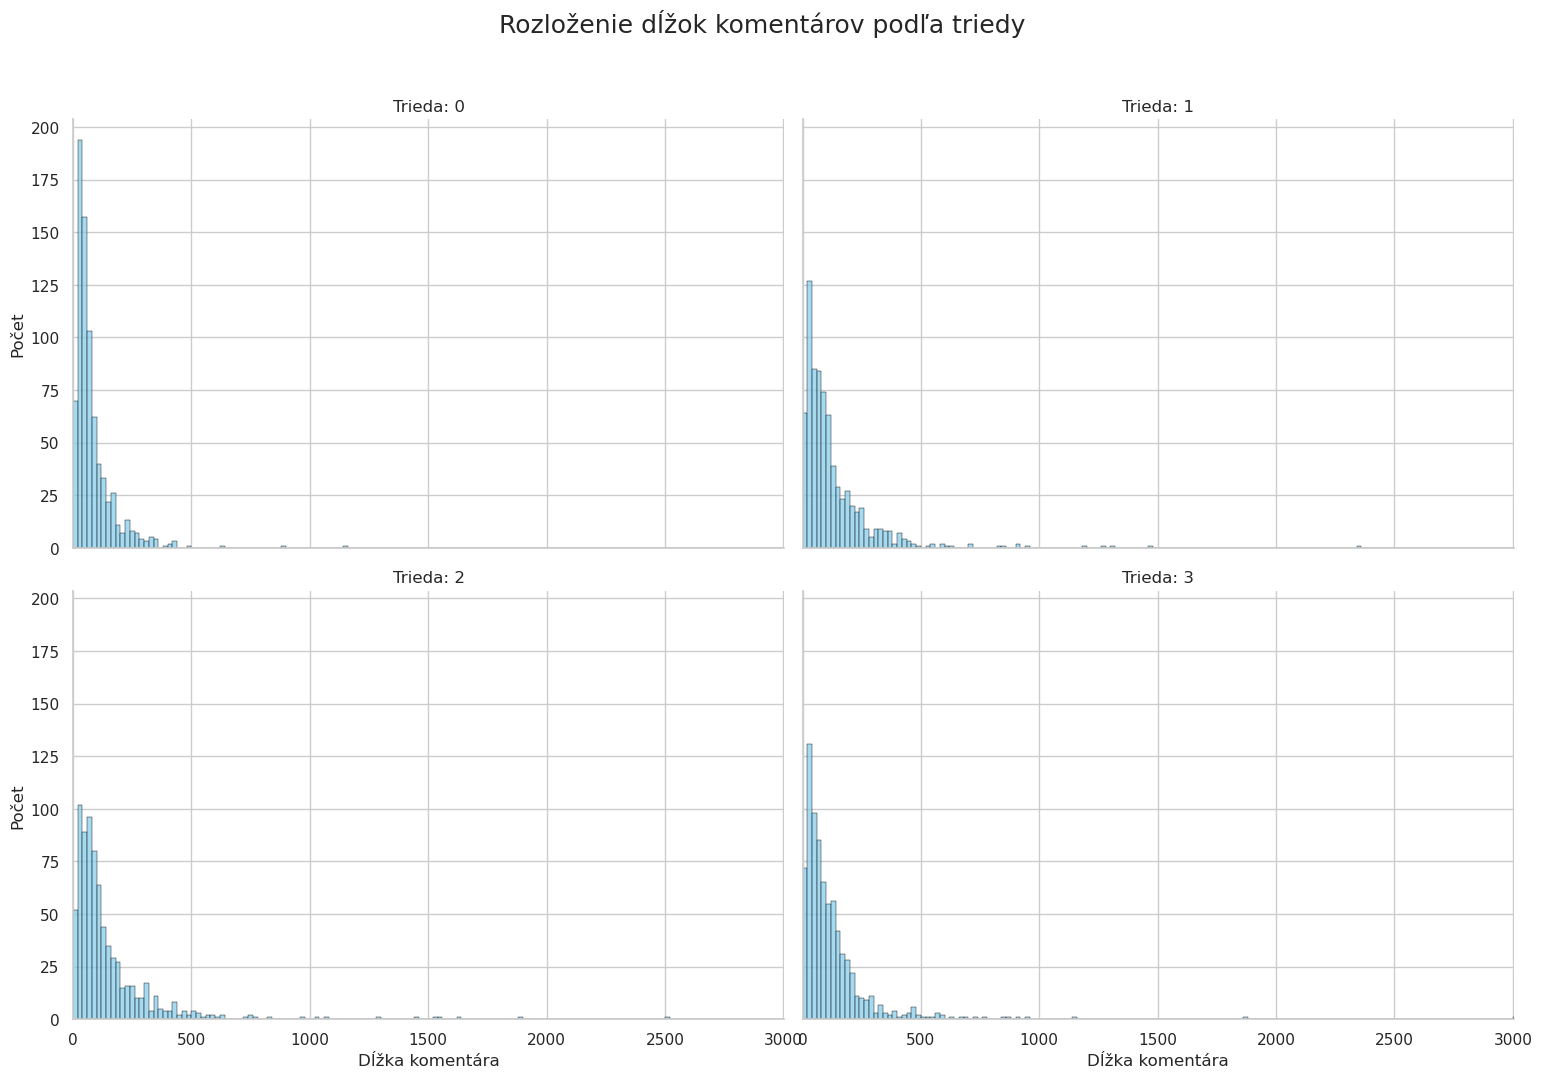

In [74]:
# Vizualizácia dĺžky komentárov
max_len = df['comment_length'].max()
bin_width = 20
bins = range(0, max_len + bin_width, bin_width)

sns.set(style="whitegrid")
g = sns.FacetGrid(df, col="label", col_wrap=2, height=5.5, aspect=1.4, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="comment_length", bins=bins, color='skyblue', edgecolor='black')

g.set_titles("Trieda: {col_name}")
g.set_axis_labels("Dĺžka komentára", "Počet")
g.set(xlim=(0, max_len))
plt.subplots_adjust(top=0.88)
g.fig.suptitle("Rozloženie dĺžok komentárov podľa triedy", fontsize=18)
plt.show()

In [75]:
# Priemerná dĺžka komentárov pre každú triedu
for level in sorted(df['label'].unique()):
    avg = df[df['label'] == level]['comment_length'].mean()
    print(f"Priemerná dĺžka komentárov pre triedu {level}: {avg:.2f}")

Priemerná dĺžka komentárov pre triedu 0: 83.18
Priemerná dĺžka komentárov pre triedu 1: 132.74
Priemerná dĺžka komentárov pre triedu 2: 149.65
Priemerná dĺžka komentárov pre triedu 3: 124.15


In [76]:
# Čistenie komentárov – aplikovanie preprocessingu
df['processed_comments'] = preprocess(
    df['Comments'],
    remove_diacritics_flag=True,
    remove_stopwords_flag=True
)

print("Ukážka čistenia komentárov:")
print(df[['Comments', 'processed_comments']].head(10))

Ukážka čistenia komentárov:
                                            Comments  \
0                                ' STRACH je svina '   
1  ' Musim bohuzial lebo natlaky vyhrazky atd Uz ...   
2  ' Ani slovko na markize v tv novinach o 17 00 ...   
3  'ESTE SA STALE NENAUCILI ZAKONY NEPREKVAPUJE M...   
4                        'V niektorych okresoch nie'   
5                       'Biznis je Matelkov biznis '   
6  'Presne o toto ide pojebat narod a hadajte sa ...   
7  'Ale ved neni poviem testovanie zaco chcu poku...   
8                        'Cela vlada nech sa pojebe'   
9  'Pomahat a chranit ale Matelka zgerba prasiva ...   

                                  processed_comments  
0                                       STRACH svina  
1  bohuzial natlaky vyhrazky atd mohli zrusit cho...  
2                     slovko markize tv novinach hod  
3                STALE NENAUCILI ZAKONY NEPREKVAPUJE  
4                                           okresoch  
5                        

In [79]:
# Analýza najčastejších slov v toxických komentároch
filtered = df[df['label'] != 0]  # Vynechávame neutrálnu triedu
words = [word for text in filtered['processed_comments'] for word in text.split()]
top_words = Counter(words).most_common(10)

print("Top 10 slov v toxických komentároch:")
for word, count in top_words:
    print(f"{word} - {count}")

Top 10 slov v toxických komentároch:
ludi - 212
ludia - 181
clovek - 104
hanba - 97
teraz - 92
chore - 80
Matovic - 77
niekto - 72
problem - 72
Matelko - 69


In [80]:
#  Uloženie datasetu
df_out = df[['processed_comments', 'label']]
df_out.columns = ['text', 'label']
df_out.to_csv('toxic_training.csv', index=False)
print("Dataset uložený ako 'toxic_training.csv'")

Dataset uložený ako 'toxic_training.csv'
